# BE Anomaly detection

PARRINO Magali

Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.decomposition import PCA

Usefull functions

In [2]:
def plotAnomalies1D(s, anomalies, threshold1, threshold2):
    """
        s: Pandas Series containing all the points to plot
        anomalies: Pandas Series containing all the points which are anomalies
        threshold1: Float value - minimum threshold to be normal
        threshold2: Float value - maximum threshold to be normal
    """
    plt.figure()
    plt.plot(s, [0]*len(s), 'bo')
    plt.plot(anomalies, [0]*len(anomalies), 'ro')
    plt.plot([threshold1]*2, [-1,1], 'g--')
    plt.plot([threshold2]*2, [-1,1], 'g--')

In [3]:
def plotAnomalies2D(df, clf_name, clf):
    """
        df: Pandas DataFrame containing all the points to plot (for features X1 and X2)
        clf_name: String value - name of the outlier detection model
        clf: Scikit Learn model instance - the trained outlier detection model
    """
    plt.figure()
    plt.plot(df['X1'],df['X2'], 'o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.xlim([df['X1'].min()-0.25,df['X1'].max()+0.25])
    plt.ylim([df['X2'].min()-0.25,df['X2'].max()+0.25])
    plt.title(clf_name)

    if clf_name == 'LOF':
        ypred = clf.fit_predict(df[['X1','X2']])
        plt.plot(df['X1'][ypred==-1],df['X2'][ypred==-1],'ro')
    else:
        xx, yy = np.meshgrid(np.linspace(df['X1'].min()-3,df['X1'].max()+3, 500), np.linspace(df['X2'].min()-3,df['X2'].max()+3, 500))
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')

## Introduction

We are trying to detect anomalies from a dataset we have no information on, except that it is data collected over 4 flight per day, during 4 days.

As we have no indication whasoever on the information contained on the dataset, it won't be possible to do novelty detection. As we do not know what is considered 'normal', if there is a large amount of data that don't differ much that should be categorized as anomalies, we won't be able to detect them.

Hence, we may deliver wrong conclusions if:

- the real amount of anomalies is too high (we won't detect everything)

- there are too few anomalies (we may mislabel normal data)

#### Data viewing

In [4]:
df = pd.read_csv("dataset.csv")
df.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237


In [5]:
# scaling the dataset so that it is not biased by the scales of the variables.

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_normalized["day_cycle_window"] = df["day_cycle_window"]
df_normalized.head()


,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,0.292587,0.233363,0.166741,0.158608,0.196520,0.344761,0.370380,0.368726,0.753675,0.710814,0.156348
1,1_1_1,0.292587,0.234097,0.167403,0.159532,0.197797,0.344805,0.371210,0.367304,0.757647,0.710754,0.156531
2,1_1_1,0.292587,0.235920,0.168507,0.159532,0.197797,0.344805,0.371210,0.367304,0.761651,0.707064,0.156531
3,1_1_1,0.291488,0.236241,0.170142,0.164945,0.205421,0.344805,0.373654,0.367304,0.765367,0.702455,0.156531
4,1_1_1,0.287371,0.236441,0.170325,0.166072,0.207157,0.344805,0.377319,0.349127,0.764725,0.689462,0.154451


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

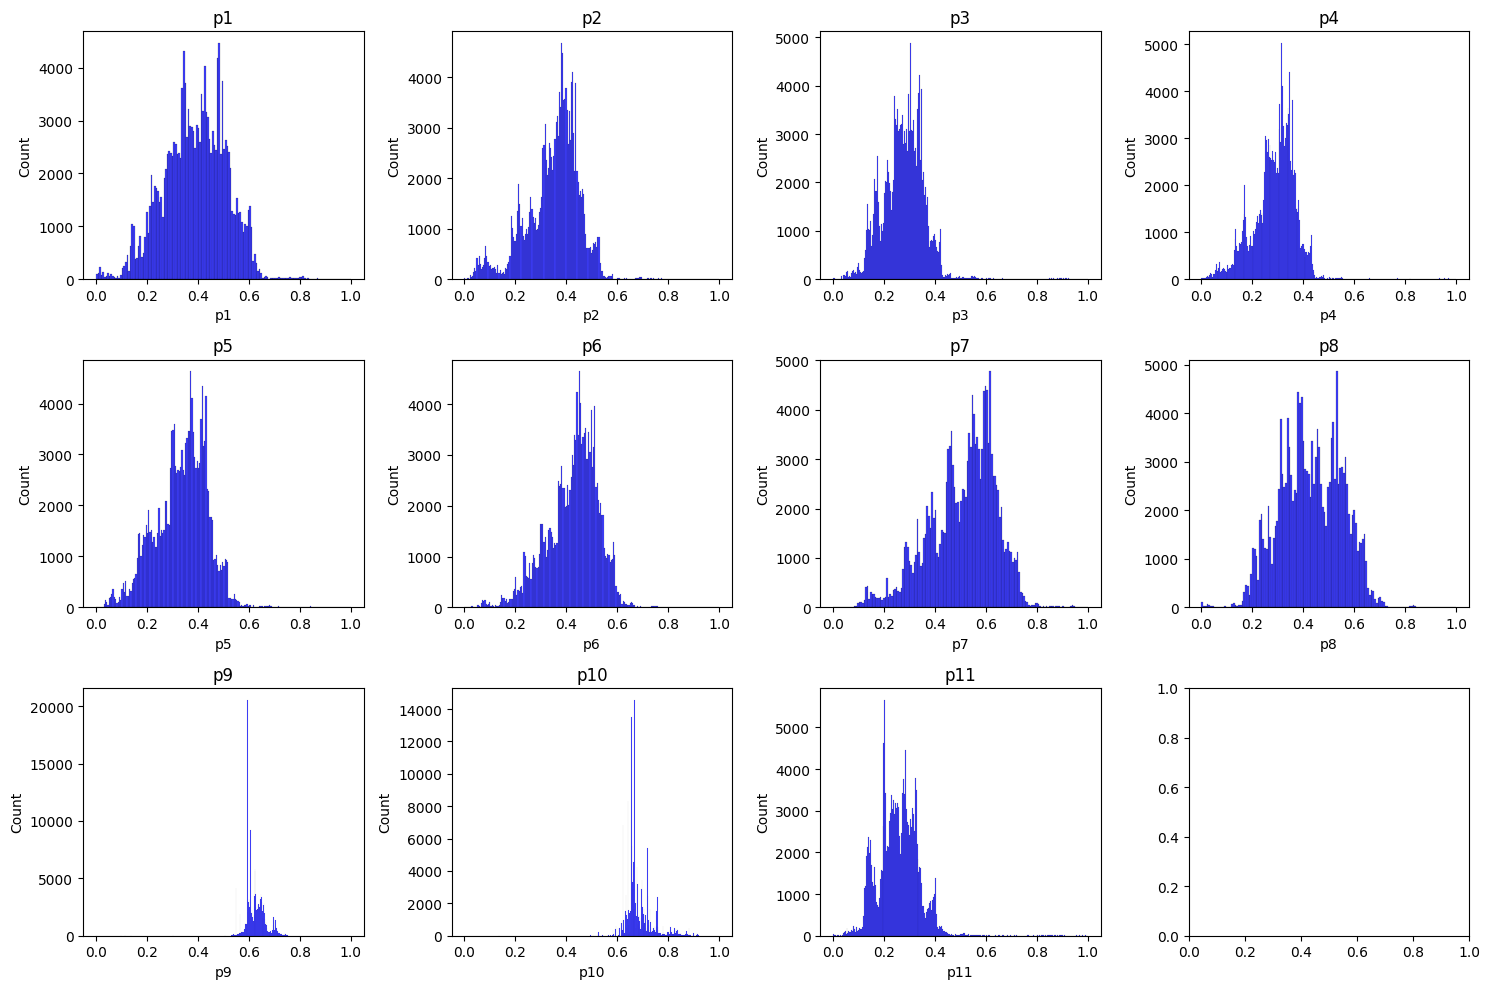

In [6]:
#First viewing of the data
col_list = []


for i in range(11):
    param = "p" + str(i+1)
    col_list.append(param)
#     sns.histplot(data=df_normalized[param])
#     plt.show()


num_rows = 3
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through the columns and plot histograms
for i in range(len(col_list)):
    param = col_list[i]
    sns.histplot(data=df_normalized[param], ax=axes[i], color='blue')
    axes[i].set_title(param)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

We can already see that some features have a much smaller variation than the other, so it was judicious to scale the data.

To analyze the dataset in order to detect anomalies, we should use statistical tools. It is not only more meaningful to study those instead of the original data, but it will also enable us to diminish the amount of data examined.

In [7]:
# creating a mean dataframe


list_of_windows=[]
index= 0
while df_normalized["day_cycle_window"][index] != '4_4_160':
    list_of_windows.append(df_normalized["day_cycle_window"][index])
    index+=100
list_of_windows.append('4_4_160')


mean_df = pd.DataFrame({'day_cycle_window': list_of_windows})

for feature in df_normalized.columns[1:]:  
    mean_values = df_normalized.groupby('day_cycle_window')[feature].mean().reset_index()
    mean_df = pd.merge(mean_df, mean_values, on='day_cycle_window', how='left')


#data visualisation
# for feature in mean_df.columns[1:]:
#     # index = 0
#     # for window in list_of_windows:
#     #     mean = np.mean(df_normalized[df_normalized["day_cycle_window"] ==window][feature] )
#     #     mean_df[feature][index] = mean
#     #     index+=1

    # plt.plot(mean_df[feature])
    # plt.title(feature)
    # plt.show()



mean_df

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,0.156316,0.097254,0.069980,0.076436,0.091970,0.225248,0.190055,0.287490,0.755550,0.605069,0.055175
1,1_1_2,0.182098,0.122018,0.066378,0.073476,0.075867,0.321200,0.231960,0.344824,0.728105,0.595102,0.042688
2,1_1_3,0.203945,0.167291,0.115782,0.131477,0.126454,0.338822,0.267098,0.328034,0.712441,0.520972,0.101450
3,1_1_4,0.218431,0.201055,0.119982,0.096193,0.110734,0.352476,0.229754,0.346382,0.712991,0.635790,0.086070
4,1_1_5,0.301398,0.285932,0.197219,0.128408,0.126975,0.426501,0.345054,0.391613,0.706772,0.629888,0.111949
...,...,...,...,...,...,...,...,...,...,...,...,...
1623,4_4_156,0.274189,0.212043,0.170959,0.160907,0.208281,0.307490,0.356735,0.304177,0.659640,0.778987,0.199818
1624,4_4_157,0.270846,0.211809,0.169392,0.162251,0.206419,0.319486,0.356565,0.303763,0.661221,0.786020,0.198836
1625,4_4_158,0.268139,0.210449,0.167495,0.161353,0.205200,0.335761,0.356417,0.303273,0.659272,0.783464,0.198643
1626,4_4_159,0.267204,0.209916,0.167123,0.159495,0.203654,0.341133,0.355010,0.301229,0.659433,0.779151,0.197714


In [8]:
# adding new columns day_cycle and day


mean_df[['day', 'cycle', 'window']] = mean_df['day_cycle_window'].str.split('_', expand=True)
mean_df['day_cycle'] = mean_df['day'] + '_' + mean_df['cycle']
mean_df['day'] = mean_df['day'].astype(int)
mean_df = mean_df.drop(['cycle', 'window'], axis=1)


mean_df

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,day,day_cycle
0,1_1_1,0.156316,0.097254,0.069980,0.076436,0.091970,0.225248,0.190055,0.287490,0.755550,0.605069,0.055175,1,1_1
1,1_1_2,0.182098,0.122018,0.066378,0.073476,0.075867,0.321200,0.231960,0.344824,0.728105,0.595102,0.042688,1,1_1
2,1_1_3,0.203945,0.167291,0.115782,0.131477,0.126454,0.338822,0.267098,0.328034,0.712441,0.520972,0.101450,1,1_1
3,1_1_4,0.218431,0.201055,0.119982,0.096193,0.110734,0.352476,0.229754,0.346382,0.712991,0.635790,0.086070,1,1_1
4,1_1_5,0.301398,0.285932,0.197219,0.128408,0.126975,0.426501,0.345054,0.391613,0.706772,0.629888,0.111949,1,1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,4_4_156,0.274189,0.212043,0.170959,0.160907,0.208281,0.307490,0.356735,0.304177,0.659640,0.778987,0.199818,4,4_4
1624,4_4_157,0.270846,0.211809,0.169392,0.162251,0.206419,0.319486,0.356565,0.303763,0.661221,0.786020,0.198836,4,4_4
1625,4_4_158,0.268139,0.210449,0.167495,0.161353,0.205200,0.335761,0.356417,0.303273,0.659272,0.783464,0.198643,4,4_4
1626,4_4_159,0.267204,0.209916,0.167123,0.159495,0.203654,0.341133,0.355010,0.301229,0.659433,0.779151,0.197714,4,4_4


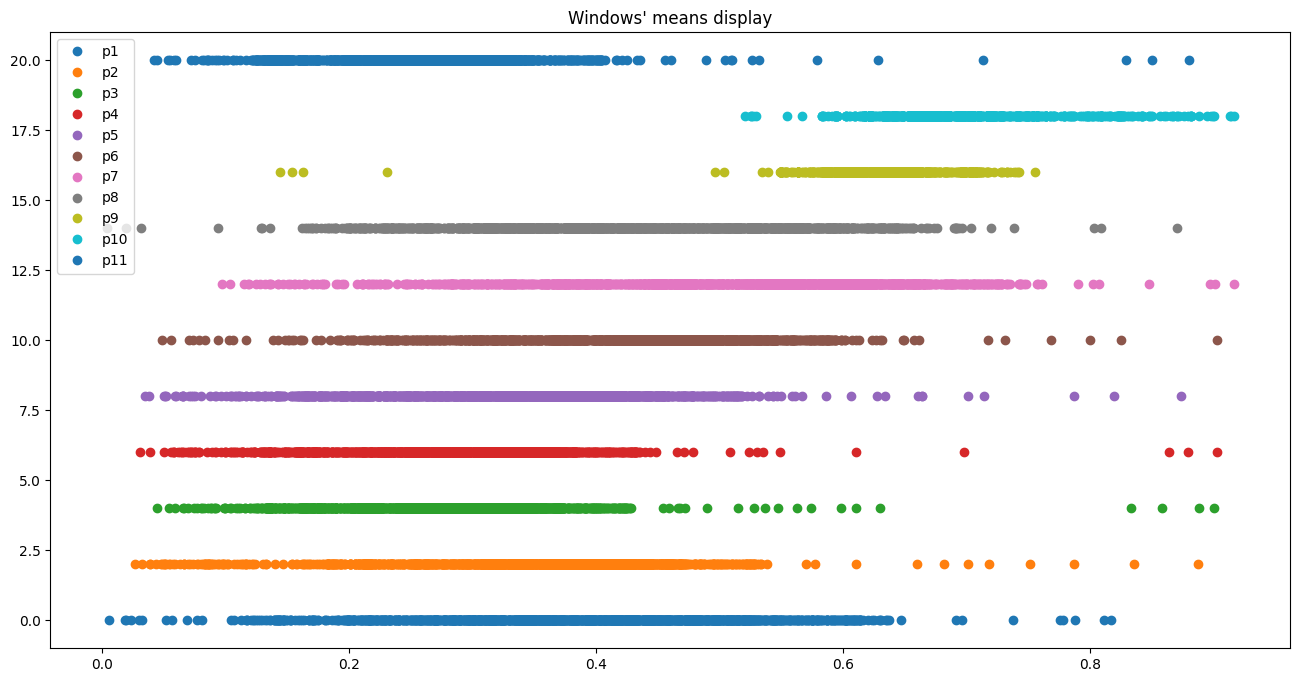

In [9]:
plt.figure(figsize=(16,8))
for i in range(11):
    x = col_list[i]
    plt.plot(mean_df[x], [i*2]*len(mean_df), 'o', label=x)
plt.title("Windows' means display")
plt.legend()

/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

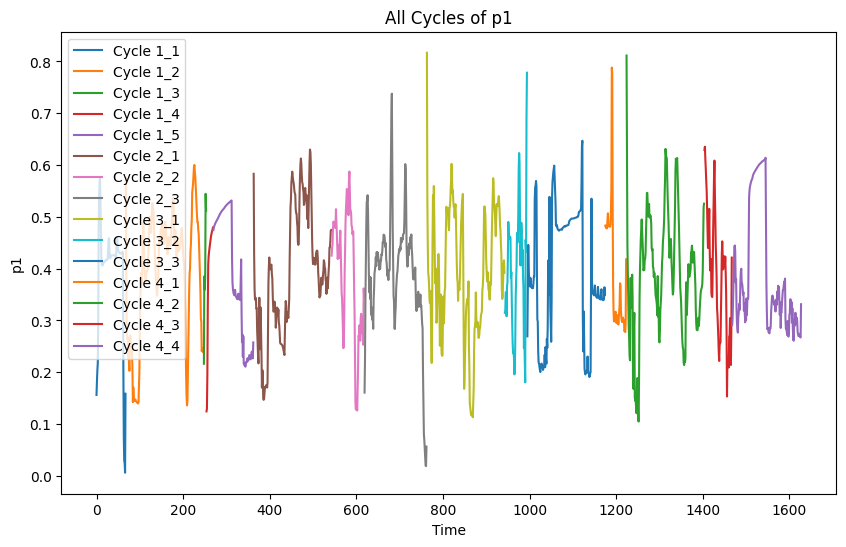

In [10]:
#trying to visualize by cycle:
feature_studied = 'p1'


plt.figure(figsize=(10, 6))  
for cycle in sorted(mean_df['day_cycle'].unique()):
    cycle_data = mean_df[mean_df['day_cycle'] == cycle]['p1']
    sns.lineplot( data=cycle_data, label=f'Cycle {cycle}')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('p1')
plt.title('All Cycles of p1')

# Show the legend
plt.legend()
plt.show()

As we can see, some cycles behave very differently. 

Though, does this mean we can analyze cycle by cycle ?

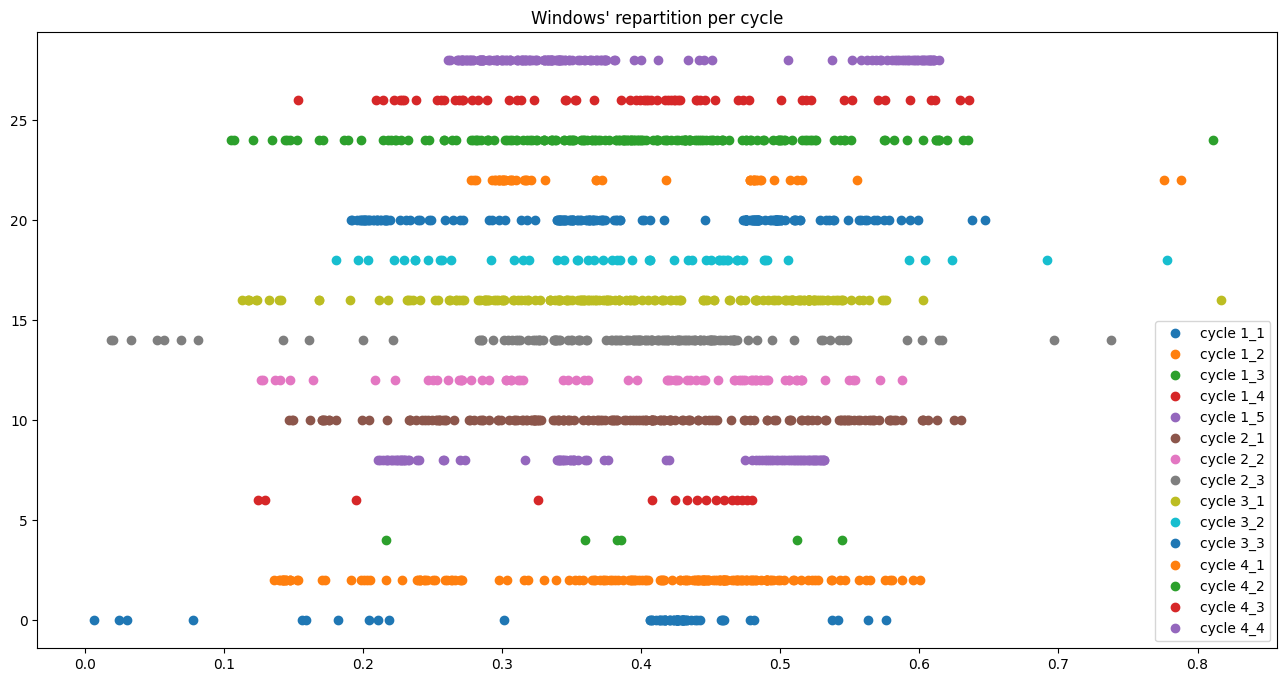

In [11]:
i=0
plt.figure(figsize=(16,8))
for cycle in sorted(mean_df['day_cycle'].unique()):
    plt.plot(mean_df[mean_df['day_cycle']==cycle]['p1'], [i*2]*len(mean_df[mean_df['day_cycle']==cycle]['p1']), 'o', label=f'cycle {cycle}')
    i+=1
plt.title("Windows' repartition per cycle")
plt.legend()

The cycles don't seem as homogeneous : it's difficult to quickly discern outliers for the cycles 1_1 (dark blue), 1_3 (green) or 1_5 (purple), if we're looking just at the first day.
As we can't seem to discern any clear pattern, it's better to focus an analysis at window scale, and not bigger.

## 1D analysis

We're going to use the Z-score for each feature

In [12]:
anomaly_list = [] 
for i in range(1,12):
    x = 'p'+str(i)
    mean = mean_df[x].mean()
    std = mean_df[x].std()

    #a threshold of 2 can be considered as lenient for a Z-score, while a threshold of 3 is deemed strict
    # As we don't have a strict strandard normal distribution, we choose a threshold in between
    threshold = 2.5 

    anomalies = mean_df[x][((mean_df[x] - mean)/std).abs() > threshold].copy()
    anomaly_list.append(anomalies)

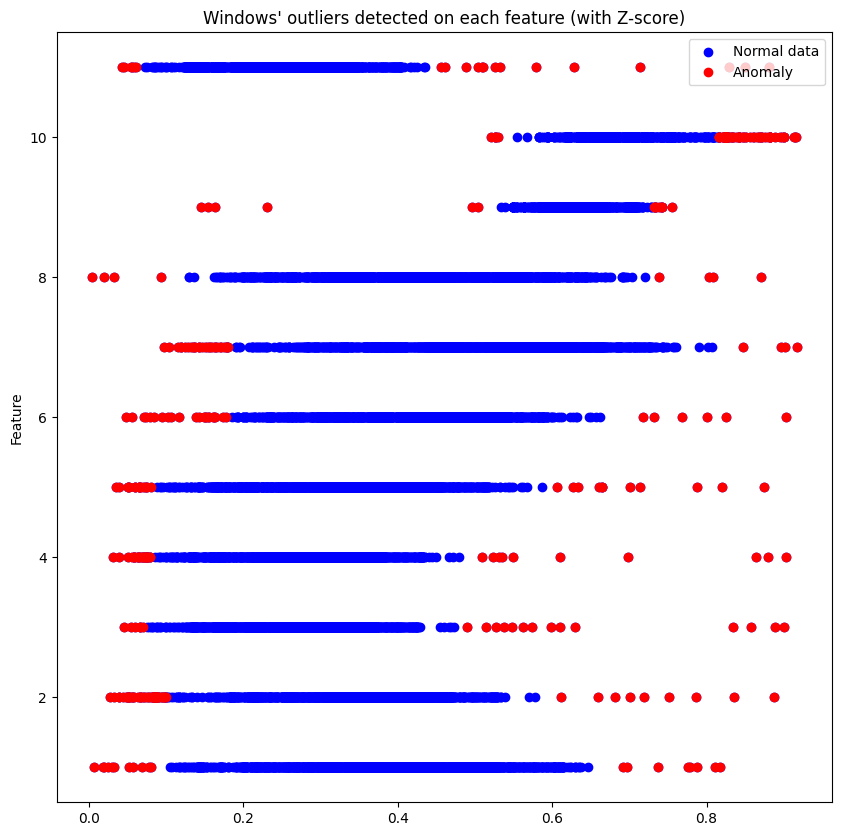

In [13]:
plt.figure(figsize=(10,10))
for i in range(11):
    x="p"+str(i+1)
    plt.scatter(mean_df[x],[i+1]*len(mean_df), color='b')
    plt.plot(anomaly_list[i], [i+1]*len(anomaly_list[i]), 'ro')


plt.title("Windows' outliers detected on each feature (with Z-score)")
plt.ylabel("Feature")

plt.legend(["Normal data", "Anomaly"])
plt.show()

As the Z-score is most pertinent when applied to standard normal distribution, we'll use another method to double check our resultst: the interquartile range (IQR).

In [14]:
anomaly_list = [] 
sorted_df = pd.DataFrame(mean_df)
for i in range(11):
    x = col_list[i]
    sorted_data = sorted_df.sort_values(by=col_list)
    q1 = np.percentile(sorted_data[x], 25)
    q3 = np.percentile(sorted_data[x], 75)
    
    IQR = q3 - q1   
    
    anomalies = mean_df[x][(mean_df[x] + 1.5 * IQR < q1) | (mean_df[x] - 0.5 * IQR > q3)].copy()
    anomaly_list.append(anomalies)

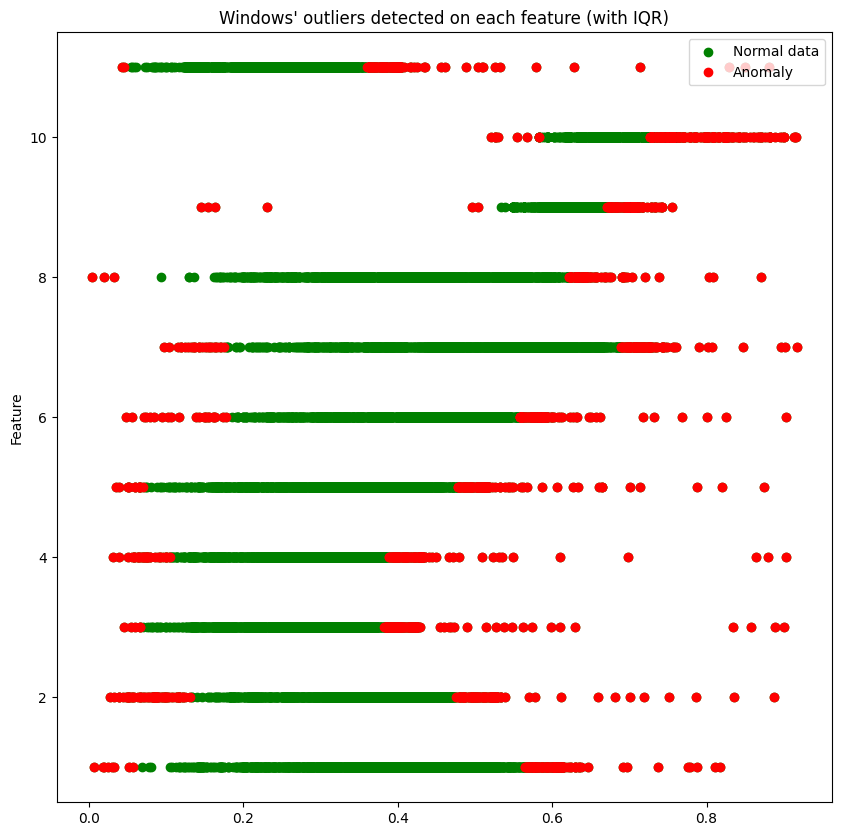

In [15]:
plt.figure(figsize=(10,10))
for i in range(11):
    x="p"+str(i+1)
    plt.scatter(mean_df[x],[i+1]*len(mean_df), color='g')
    plt.plot(anomaly_list[i], [i+1]*len(anomaly_list[i]), 'ro')


plt.title("Windows' outliers detected on each feature (with IQR)")
plt.ylabel("Feature")

plt.legend(["Normal data", "Anomaly"])
plt.show()

We have calculated the interquartile range (IQR) and identified data points that fall outside the range (1.5 times the IQR below the first quartile or above the third quartile).

The results differ from the Z-score method, and are probably more reliable. This reminds us that we must be mindful of the method used to detect anomalies.

However, even if outliers have been detected, they may not be all correct: as we study feature by feature, a window may be categorized as an anomaly for one feature but considered normal for another feature.



## Multidimentional analysis

Reducing the number of parameters via PCA can be usefull for a clearer representation. We don't mind loosing the understanding of the features, as we already don't know them. Howerver we might loose some information.

We'll see if by using the PCA we loose too much information. 

We'll still use it for a clearer representation of the methods either way.

Standar deviation due to the 2 componants kept : 0.7618940268464373


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='X1', ylabel='X2'>

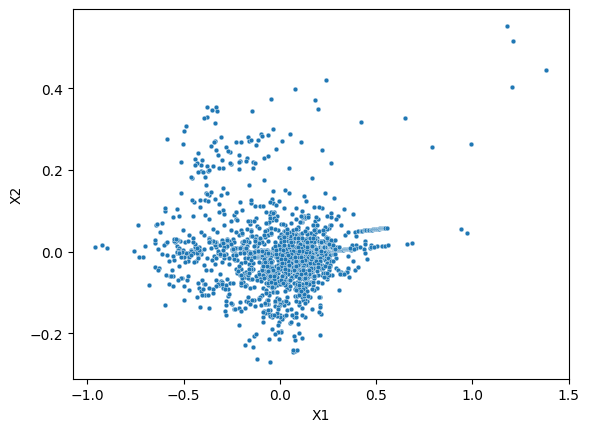

In [16]:
# reducing number of parameters : PCA

pca_df = mean_df.drop(columns=['day_cycle_window', 'day_cycle', 'day'])

wo_PCA_df = mean_df.drop(columns=['day_cycle_window', 'day_cycle', 'day'])

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(pca_df)
reduced_data = pca.transform(pca_df)
reduced_df = pd.DataFrame(reduced_data, columns=['X' + str(i+1) for i in range(n_components)])
print("Standar deviation due to the {} componants kept : ".format(n_components) + str(np.sum(pca.explained_variance_ratio_[:n_components])))
sns.scatterplot(data=reduced_df, x='X1', y='X2', s=12)



The explainability of the first 2 parameters is 76%, which is correct but not outstanding.

In the following section, we'll compare different methods

/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(


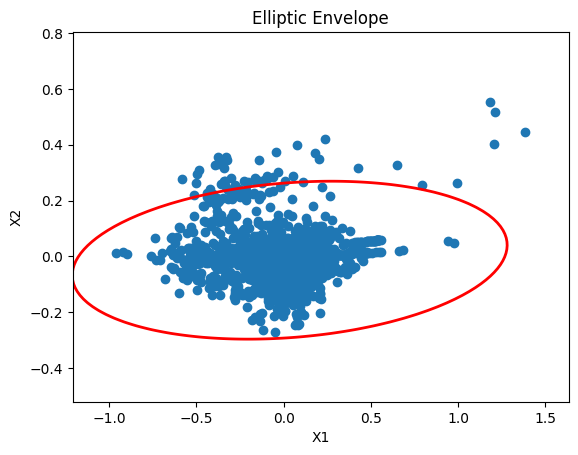

In [17]:
from sklearn.covariance import EllipticEnvelope
clf_name = 'Elliptic Envelope'
clf = EllipticEnvelope(contamination=0.03)
clf.fit(reduced_df)
plotAnomalies2D(reduced_df[['X1', 'X2']], clf_name, clf)

/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


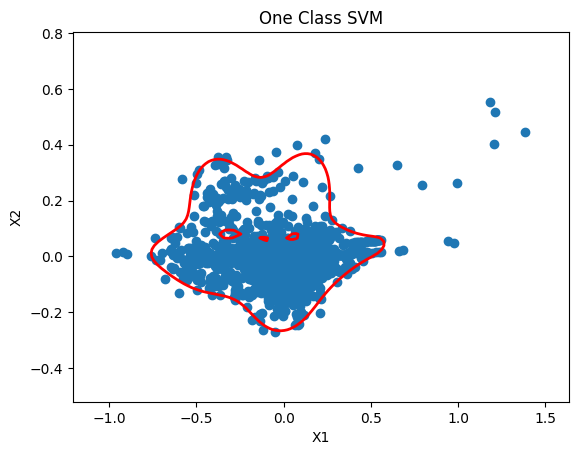

In [18]:
from sklearn.svm import OneClassSVM
clf_name = 'One Class SVM'
clf = OneClassSVM(nu=0.03, kernel="rbf", gamma=20) # nu corresponds to contamination
clf.fit(reduced_df[['X1','X2']])
plotAnomalies2D(reduced_df[['X1', 'X2']], clf_name, clf)

/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


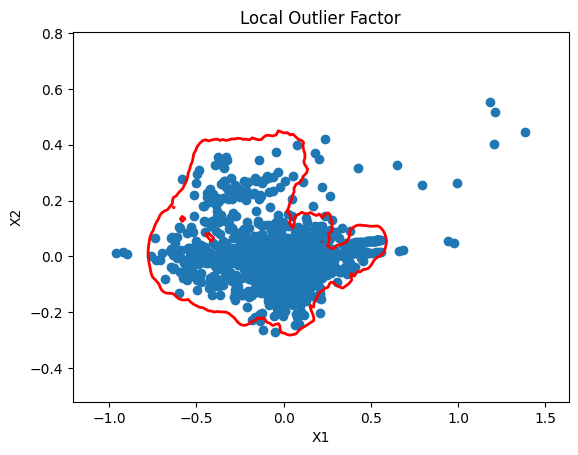

In [19]:
from sklearn.neighbors import LocalOutlierFactor
clf_name = 'Local Outlier Factor'
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.03, novelty=True)
clf.fit(reduced_df[['X1','X2']])
plotAnomalies2D(reduced_df[['X1', 'X2']], clf_name, clf)

/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


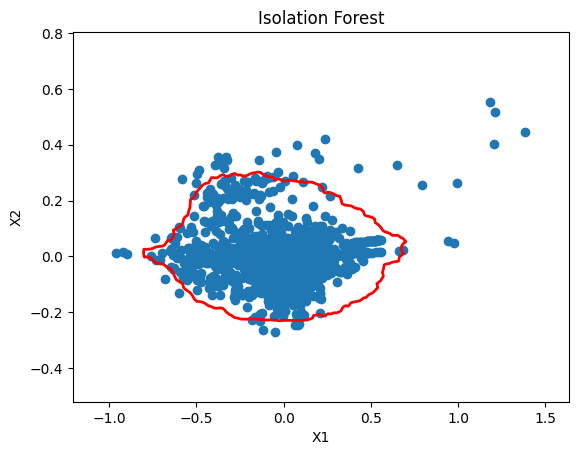

In [20]:
from sklearn.ensemble import IsolationForest
clf_name = 'Isolation Forest'
clf = IsolationForest(n_estimators=100, contamination=0.03)
clf.fit(reduced_df)
y_pred=clf.predict(reduced_df[['X1','X2']])
reduced_df.insert(2,"Prediction",y_pred)
plotAnomalies2D(reduced_df[['X1', 'X2']], clf_name, clf)

The tuning of the different models was done graphically.

All the methods provide precise results, except the Elliptic enveloppe.
However, the Isolation Forest has the advantage of being able to handle high dimentional data, in case the PCA is not precise enough. We'll therefore select this method.

In [21]:
# Isolation forest on the original features
clf_name = 'Isolation Forest'
clf2 = IsolationForest(n_estimators=100, contamination=0.03)
clf2.fit(wo_PCA_df)
y_pred2=clf2.predict(wo_PCA_df)
mean_df.insert(14 ,"Prediction_wo_PCA",y_pred2)


In [22]:
#categorizing windows as anomalies (-1) or normal data (1)

y_pred=clf.predict(reduced_df[['X1','X2']])
# reduced_df.insert(2, "Prediction",y_pred)


mean_df.insert(15, "Prediction",y_pred)
mean_df

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,day,day_cycle,Prediction_wo_PCA,Prediction
0,1_1_1,0.156316,0.097254,0.069980,0.076436,0.091970,0.225248,0.190055,0.287490,0.755550,0.605069,0.055175,1,1_1,-1,-1
1,1_1_2,0.182098,0.122018,0.066378,0.073476,0.075867,0.321200,0.231960,0.344824,0.728105,0.595102,0.042688,1,1_1,-1,-1
2,1_1_3,0.203945,0.167291,0.115782,0.131477,0.126454,0.338822,0.267098,0.328034,0.712441,0.520972,0.101450,1,1_1,-1,1
3,1_1_4,0.218431,0.201055,0.119982,0.096193,0.110734,0.352476,0.229754,0.346382,0.712991,0.635790,0.086070,1,1_1,-1,1
4,1_1_5,0.301398,0.285932,0.197219,0.128408,0.126975,0.426501,0.345054,0.391613,0.706772,0.629888,0.111949,1,1_1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,4_4_156,0.274189,0.212043,0.170959,0.160907,0.208281,0.307490,0.356735,0.304177,0.659640,0.778987,0.199818,4,4_4,1,1
1624,4_4_157,0.270846,0.211809,0.169392,0.162251,0.206419,0.319486,0.356565,0.303763,0.661221,0.786020,0.198836,4,4_4,1,1
1625,4_4_158,0.268139,0.210449,0.167495,0.161353,0.205200,0.335761,0.356417,0.303273,0.659272,0.783464,0.198643,4,4_4,1,1
1626,4_4_159,0.267204,0.209916,0.167123,0.159495,0.203654,0.341133,0.355010,0.301229,0.659433,0.779151,0.197714,4,4_4,1,1


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and

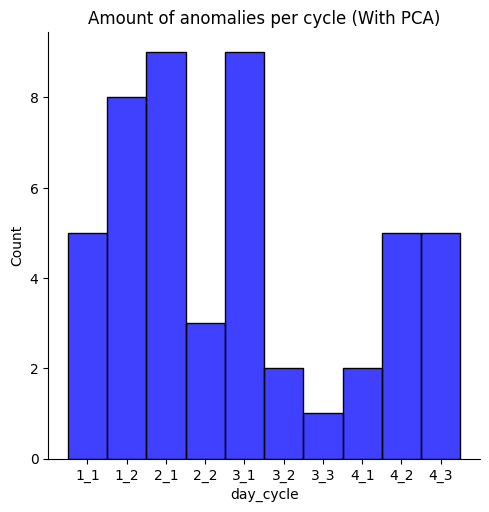

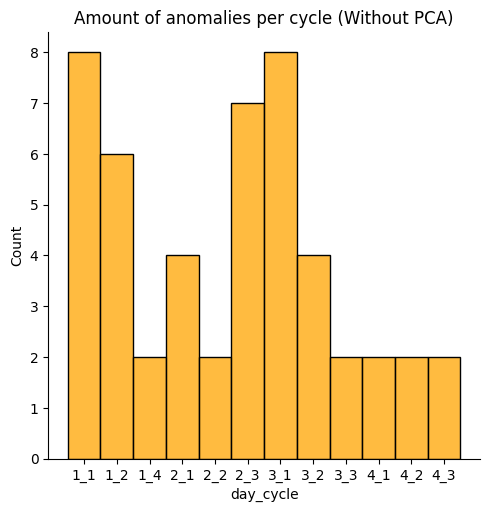

In [23]:
# bar diagram representing the number of anomalies per cycle
anomaly_df = mean_df[mean_df.Prediction == -1]
anomaly2_df = mean_df[mean_df.Prediction_wo_PCA == -1]



sns.displot(data = anomaly_df, x='day_cycle', color = 'blue')
plt.title('Amount of anomalies per cycle (With PCA)')

sns.displot(data = anomaly2_df, x='day_cycle', color = 'orange')
plt.title('Amount of anomalies per cycle (Without PCA)')

plt.show()



As we can see by comparison of the 2 barplots, we don't have the same anomalies whether we use the predictions coming from the PCA or from the original data. In order to have as much accuracy as possible, we'll use the PCA only for clearer visualization, but the analysis will be based on the original data.


/tmp/ipykernel_37315/3251413459.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mean_df[x],[i+1]*len(mean_df),c=color_df['Color'], cmap='viridis')


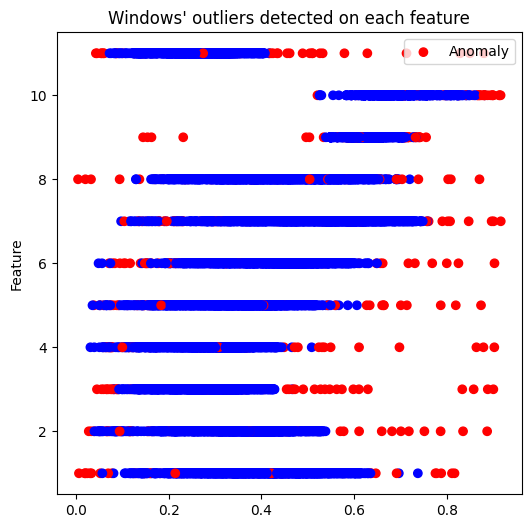

In [24]:
# Diplay of the anomalies' repartition is their respective features

color_mapping = {1: 'blue', -1: 'red'}

# Use the map function to create a new 'Color' column based on the values
color_df = pd.DataFrame({'Color': mean_df['Prediction_wo_PCA'].map(color_mapping)})



plt.figure(figsize=(6,6))
for i in range(11):
  x="p"+str(i+1)
  plt.scatter(mean_df[x],[i+1]*len(mean_df),c=color_df['Color'], cmap='viridis')
plt.title("Windows' outliers detected on each feature")
plt.ylabel("Feature")
plt.legend(['Anomaly'])

plt.show()

We can see that we obtain globaly the same results as those in 1D, wich is coherent. They may not be exactly the same, but overall they have similarities.

### Taking into account other statistical measures

So far we have only used the mean to analize data. But there are other statistical metrics that are usefull in order to detect outliers. 

There are usually several metrics available:

- The mean (that we studied already)
- Median
- Standard deviation
- Variance
- Interquartile Range, IQR
- Minimum
- Maximum
- Quartiles
- Skewness
- Kurtosis
- Variation coefficient
- ...


We'll study the median, minimum, maximum and standard deviation as well.

We make this choice in order to not overcharge with information, and we selected these metrics because they are easily understandable.

If needed, a deeper study could be conducted at the demand of experts.


In [25]:
std_df = pd.DataFrame({'day_cycle_window': list_of_windows, 'day_cycle': mean_df["day_cycle"], 'day': mean_df["day"]})

for feature in col_list:  
    std_values = df_normalized.groupby('day_cycle_window')[feature].std().reset_index()
    std_df = pd.merge(std_df, std_values, on='day_cycle_window', how='left')
    std_df.rename(columns={feature: f'{feature}_std'}, inplace=True)


std_df.head()


,day_cycle_window,day_cycle,day,p1_std,p2_std,p3_std,p4_std,p5_std,p6_std,p7_std,p8_std,p9_std,p10_std,p11_std
0,1_1_1,1_1,1,0.071865,0.076597,0.055203,0.053821,0.070968,0.075414,0.087329,0.094144,0.011238,0.038197,0.058482
1,1_1_2,1_1,1,0.024009,0.011304,0.008261,0.011447,0.013951,0.019897,0.018525,0.023559,0.005927,0.028226,0.021155
2,1_1_3,1_1,1,0.055786,0.048050,0.040710,0.041528,0.042034,0.070663,0.057613,0.077208,0.009187,0.026039,0.038331
3,1_1_4,1_1,1,0.021551,0.022279,0.013768,0.007664,0.006042,0.020753,0.019507,0.025012,0.004308,0.022589,0.008687
4,1_1_5,1_1,1,0.047041,0.055584,0.052250,0.058366,0.063145,0.039580,0.085229,0.038530,0.052046,0.069100,0.064898


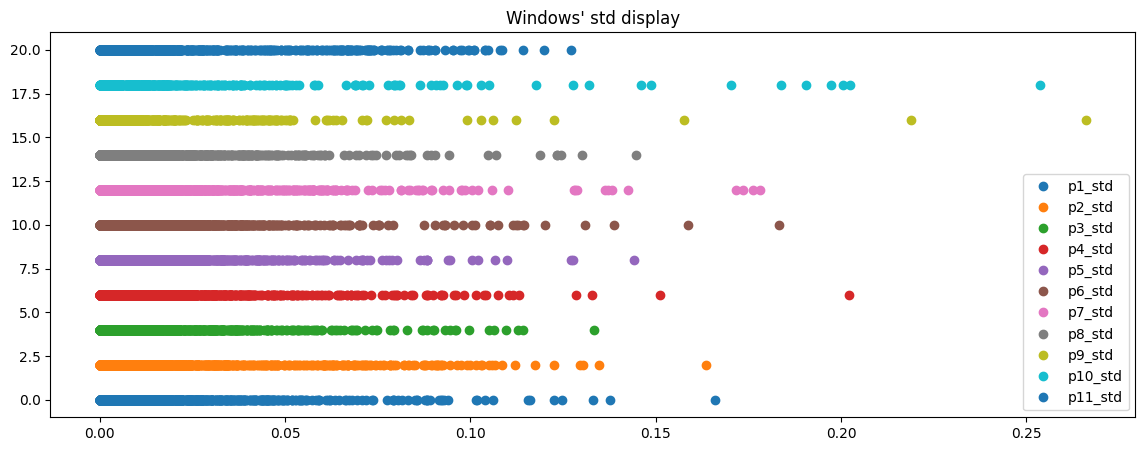

In [26]:
plt.figure(figsize=(14,5))
for i in range(11):
    x = col_list[i] + "_std"
    plt.plot(std_df[x], [i*2]*len(std_df), 'o', label=x)
plt.title("Windows' std display")
plt.legend()

In [27]:
med_df = pd.DataFrame({'day_cycle_window': list_of_windows, 'day_cycle': mean_df["day_cycle"], 'day': mean_df["day"]})

for feature in col_list:  
    med_values = df_normalized.groupby('day_cycle_window')[feature].median().reset_index()
    med_df = pd.merge(med_df, med_values, on='day_cycle_window', how='left')
    med_df.rename(columns={feature: f'{feature}_med'}, inplace=True)
med_df.head()


,day_cycle_window,day_cycle,day,p1_med,p2_med,p3_med,p4_med,p5_med,p6_med,p7_med,p8_med,p9_med,p10_med,p11_med
0,1_1_1,1_1,1,0.165692,0.085955,0.053168,0.060130,0.085225,0.241097,0.180056,0.331885,0.748651,0.583640,0.026289
1,1_1_2,1_1,1,0.171881,0.123967,0.065301,0.076382,0.078193,0.319667,0.238986,0.347992,0.726285,0.587073,0.049073
2,1_1_3,1_1,1,0.214348,0.169930,0.115430,0.135994,0.129600,0.357613,0.265477,0.343295,0.713476,0.509569,0.089011
3,1_1_4,1_1,1,0.220476,0.209754,0.124605,0.096329,0.112366,0.355066,0.238484,0.350148,0.712334,0.641905,0.088832
4,1_1_5,1_1,1,0.284157,0.267944,0.175900,0.101445,0.086619,0.425174,0.320496,0.391678,0.727097,0.612115,0.065550


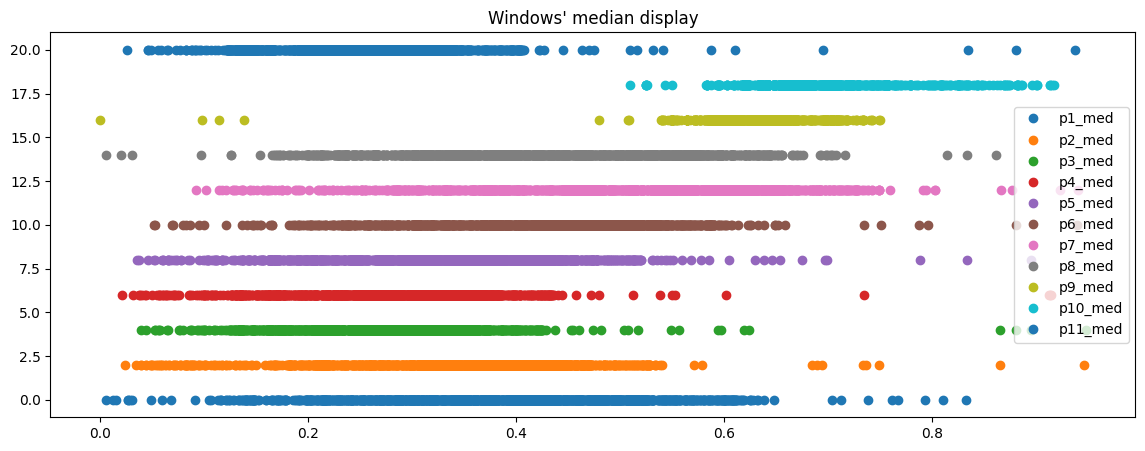

In [28]:
plt.figure(figsize=(14,5))
for i in range(11):
    x = col_list[i] + "_med"
    plt.plot(med_df[x], [i*2]*len(med_df), 'o', label=x)
plt.title("Windows' median display")
plt.legend()

In [29]:
max_df = pd.DataFrame({'day_cycle_window': list_of_windows, 'day_cycle': mean_df["day_cycle"], 'day': mean_df["day"]})

for feature in col_list:  
    max_values = df_normalized.groupby('day_cycle_window')[feature].max().reset_index()
    max_df = pd.merge(max_df, max_values, on='day_cycle_window', how='left')
    max_df.rename(columns={feature: f'{feature}_max'}, inplace=True)

max_df.head()

,day_cycle_window,day_cycle,day,p1_max,p2_max,p3_max,p4_max,p5_max,p6_max,p7_max,p8_max,p9_max,p10_max,p11_max
0,1_1_1,1_1,1,0.292587,0.236441,0.170325,0.166911,0.209536,0.344805,0.377319,0.396365,0.778237,0.710814,0.156531
1,1_1_2,1_1,1,0.228676,0.141476,0.079678,0.088250,0.099192,0.354167,0.257564,0.395147,0.748373,0.638923,0.071102
2,1_1_3,1_1,1,0.270438,0.232470,0.172880,0.187141,0.187169,0.439854,0.350456,0.439864,0.727292,0.581773,0.158333
3,1_1_4,1_1,1,0.242456,0.218802,0.134341,0.105317,0.117257,0.381956,0.245262,0.392990,0.725752,0.663034,0.096354
4,1_1_5,1_1,1,0.398345,0.395844,0.308119,0.242780,0.241557,0.513108,0.529294,0.473145,0.755761,0.884804,0.236767


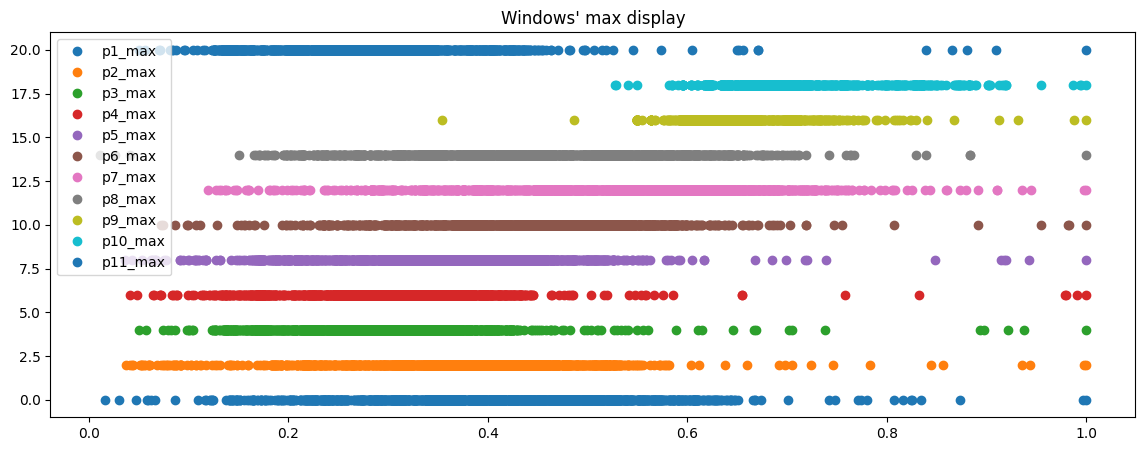

In [30]:
plt.figure(figsize=(14,5))
for i in range(11):
    x = col_list[i] + "_max"
    plt.plot(max_df[x], [i*2]*len(max_df), 'o', label=x)
plt.title("Windows' max display")
plt.legend()

In [31]:
min_df = pd.DataFrame({'day_cycle_window': list_of_windows, 'day_cycle': mean_df["day_cycle"], 'day': mean_df["day"]})

for feature in col_list:  
    min_values = df_normalized.groupby('day_cycle_window')[feature].min().reset_index()
    min_df = pd.merge(min_df, min_values, on='day_cycle_window', how='left')
    min_df.rename(columns={feature: f'{feature}_min'}, inplace=True)

min_df.head()

,day_cycle_window,day_cycle,day,p1_min,p2_min,p3_min,p4_min,p5_min,p6_min,p7_min,p8_min,p9_min,p10_min,p11_min
0,1_1_1,1_1,1,0.012681,0.000000,0.003869,0.019227,0.000000,0.071770,0.065002,0.096654,0.744498,0.553296,0.000000
1,1_1_2,1_1,1,0.152930,0.095718,0.052498,0.042820,0.040433,0.290876,0.186431,0.307680,0.724451,0.563704,0.004119
2,1_1_3,1_1,1,0.093518,0.092547,0.060713,0.070078,0.062672,0.212142,0.171870,0.190589,0.699702,0.495206,0.053013
3,1_1_4,1_1,1,0.127173,0.130994,0.079135,0.079917,0.096584,0.274396,0.178732,0.260708,0.708227,0.592593,0.065550
4,1_1_5,1_1,1,0.233918,0.202594,0.134341,0.067267,0.070498,0.360309,0.226015,0.319107,0.605924,0.564699,0.053550


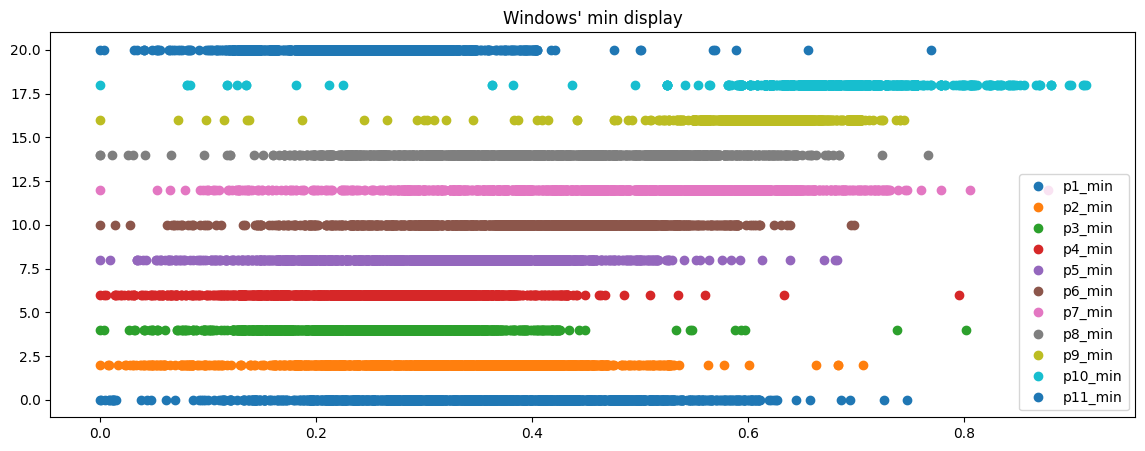

In [32]:
plt.figure(figsize=(14,5))
for i in range(11):
    x = col_list[i] + "_min"
    plt.plot(min_df[x], [i*2]*len(min_df), 'o', label=x)
plt.title("Windows' min display")
plt.legend()

All those metrics seam to diplay obvious outliers. Altough, are they corresponding to the same windows each time ?

Let's take the example of the first feature to see the repartition of the anomalies detected thanks to the mean on the other metrics:

In [33]:
#creation of a general dataframe:

bare_mean_df = mean_df.drop(columns=["day_cycle_window","day", "day_cycle", "Prediction_wo_PCA", "Prediction"])
bare_std_df = std_df.drop(columns=["day_cycle_window","day", "day_cycle"])
bare_med_df = med_df.drop(columns=["day_cycle_window","day", "day_cycle"])
bare_max_df = max_df.drop(columns=["day_cycle_window","day", "day_cycle"])
bare_min_df = min_df.drop(columns=["day_cycle_window","day", "day_cycle"])

general_df = pd.concat([bare_mean_df,bare_std_df, bare_med_df, bare_max_df, bare_min_df],axis=1)
general_df

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p2_min,p3_min,p4_min,p5_min,p6_min,p7_min,p8_min,p9_min,p10_min,p11_min
0,0.156316,0.097254,0.069980,0.076436,0.091970,0.225248,0.190055,0.287490,0.755550,0.605069,...,0.000000,0.003869,0.019227,0.000000,0.071770,0.065002,0.096654,0.744498,0.553296,0.000000
1,0.182098,0.122018,0.066378,0.073476,0.075867,0.321200,0.231960,0.344824,0.728105,0.595102,...,0.095718,0.052498,0.042820,0.040433,0.290876,0.186431,0.307680,0.724451,0.563704,0.004119
2,0.203945,0.167291,0.115782,0.131477,0.126454,0.338822,0.267098,0.328034,0.712441,0.520972,...,0.092547,0.060713,0.070078,0.062672,0.212142,0.171870,0.190589,0.699702,0.495206,0.053013
3,0.218431,0.201055,0.119982,0.096193,0.110734,0.352476,0.229754,0.346382,0.712991,0.635790,...,0.130994,0.079135,0.079917,0.096584,0.274396,0.178732,0.260708,0.708227,0.592593,0.065550
4,0.301398,0.285932,0.197219,0.128408,0.126975,0.426501,0.345054,0.391613,0.706772,0.629888,...,0.202594,0.134341,0.067267,0.070498,0.360309,0.226015,0.319107,0.605924,0.564699,0.053550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0.274189,0.212043,0.170959,0.160907,0.208281,0.307490,0.356735,0.304177,0.659640,0.778987,...,0.209884,0.168415,0.158406,0.207656,0.306541,0.354841,0.303254,0.657759,0.778231,0.198013
1624,0.270846,0.211809,0.169392,0.162251,0.206419,0.319486,0.356565,0.303763,0.661221,0.786020,...,0.192640,0.158439,0.151573,0.192892,0.310353,0.338857,0.289552,0.658003,0.778296,0.188007
1625,0.268139,0.210449,0.167495,0.161353,0.205200,0.335761,0.356417,0.303273,0.659272,0.783464,...,0.206172,0.163131,0.157552,0.201837,0.329338,0.352459,0.299923,0.657657,0.778231,0.193783
1626,0.267204,0.209916,0.167123,0.159495,0.203654,0.341133,0.355010,0.301229,0.659433,0.779151,...,0.206241,0.161782,0.156138,0.200364,0.337310,0.352706,0.298545,0.656730,0.778458,0.193430


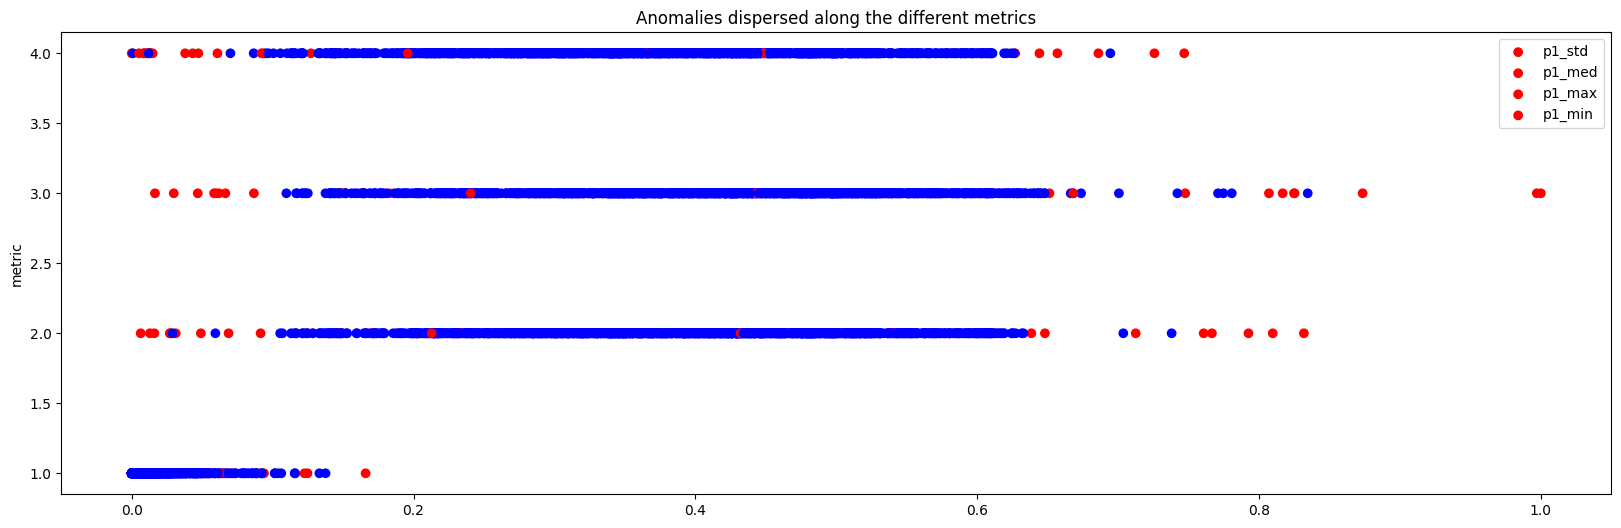

In [34]:
color_mapping = {1: 'blue', -1: 'red'}

# Use the map function to create a new 'Color' column based on the values
color_df = pd.DataFrame({'Color': mean_df['Prediction_wo_PCA'].map(color_mapping)})

list_metric = ["std", "med", "max", "min"]

plt.figure(figsize=(20,6))


for i in range(4):
  x="p1_"+ list_metric[i]
  plt.scatter(general_df[x],[i+1]*len(general_df),c=color_df['Color'], label = x)
  
plt.title("Anomalies dispersed along the different metrics")
plt.ylabel("metric")
plt.legend()


We can see that the part of the obvious outliers are also deemed as such in the other metrics, but some outliers seem to be in the general mass as well.

We'll therefore reapply our model Isolation Forest to the full general dataset to see the difference.

Standar deviation due to the 2 componants kept : 0.7207136904005393


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='X1', ylabel='X2'>

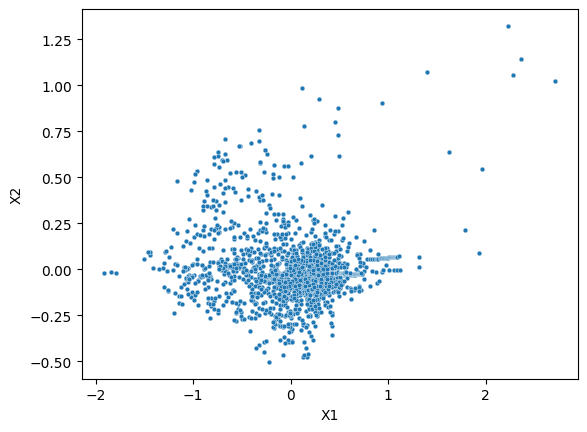

In [35]:
#PCA for better display

n_components = 2
pca = PCA(n_components=n_components)
pca.fit(general_df)
pca_general_data = pca.transform(general_df)
pca_general_df = pd.DataFrame(pca_general_data, columns=['X' + str(i+1) for i in range(n_components)])
print("Standar deviation due to the {} componants kept : ".format(n_components) + str(np.sum(pca.explained_variance_ratio_[:n_components])))
sns.scatterplot(data=pca_general_df, x='X1', y='X2', s=12)


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


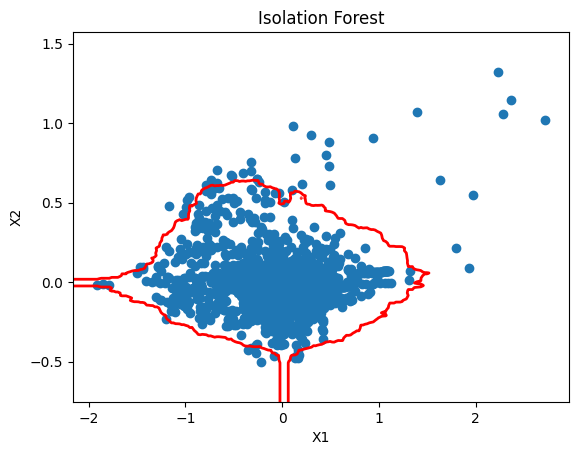

In [36]:

clf_name = 'Isolation Forest'
clf3 = IsolationForest(n_estimators=100, contamination=0.03)
clf3.fit(pca_general_df)
# y_pred=clf.predict(reduced_df[['X1','X2']])
# reduced_df.insert(2,"Prediction",y_pred)
plotAnomalies2D(pca_general_df[['X1', 'X2']], clf_name, clf3)

In [37]:
clf_name = 'Isolation Forest'
clf4 = IsolationForest(n_estimators=100, contamination=0.03)
clf4.fit(general_df)



IsolationForest(contamination=0.03)

In [38]:

y_pred3=clf3.predict(pca_general_df) #prediction for all the metrics with the PCA
y_pred4=clf4.predict(general_df) #prediciton for all the metrics without the PCA

general_df.insert(55,"mean_pred",y_pred2) # prediction from only the mean_df without PCA
general_df.insert(56, "General_pred", y_pred3) 
general_df.insert(57,"General_pred_wo_PCA",y_pred4)
general_df.insert(58, "day_cycle",mean_df["day_cycle"])
general_df.insert(59,'day_cycle_window', mean_df['day_cycle_window'])

general_df.head()


,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p7_min,p8_min,p9_min,p10_min,p11_min,mean_pred,General_pred,General_pred_wo_PCA,day_cycle,day_cycle_window
0,0.156316,0.097254,0.069980,0.076436,0.091970,0.225248,0.190055,0.287490,0.755550,0.605069,...,0.065002,0.096654,0.744498,0.553296,0.000000,-1,1,-1,1_1,1_1_1
1,0.182098,0.122018,0.066378,0.073476,0.075867,0.321200,0.231960,0.344824,0.728105,0.595102,...,0.186431,0.307680,0.724451,0.563704,0.004119,-1,-1,-1,1_1,1_1_2
2,0.203945,0.167291,0.115782,0.131477,0.126454,0.338822,0.267098,0.328034,0.712441,0.520972,...,0.171870,0.190589,0.699702,0.495206,0.053013,-1,1,1,1_1,1_1_3
3,0.218431,0.201055,0.119982,0.096193,0.110734,0.352476,0.229754,0.346382,0.712991,0.635790,...,0.178732,0.260708,0.708227,0.592593,0.065550,-1,1,1,1_1,1_1_4
4,0.301398,0.285932,0.197219,0.128408,0.126975,0.426501,0.345054,0.391613,0.706772,0.629888,...,0.226015,0.319107,0.605924,0.564699,0.053550,1,1,-1,1_1,1_1_5


In [39]:
#comparing the predictions of the mean and the general metrics, both without PCA (we study wo PCA, it is only usefull to display)

anomaly_df = general_df[general_df.mean_pred == -1]
anomaly2_df = general_df[general_df.General_pred_wo_PCA == -1]

studied_col = col_list
studied_col.append('day_cycle')


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/magaliparrino/.local/bin/SDD-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


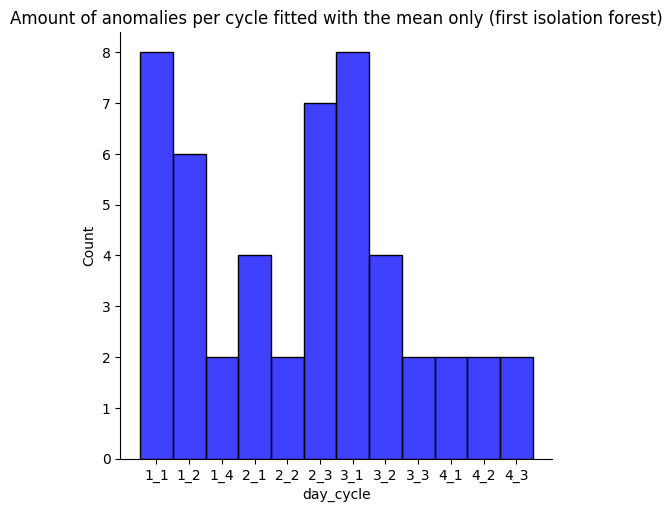

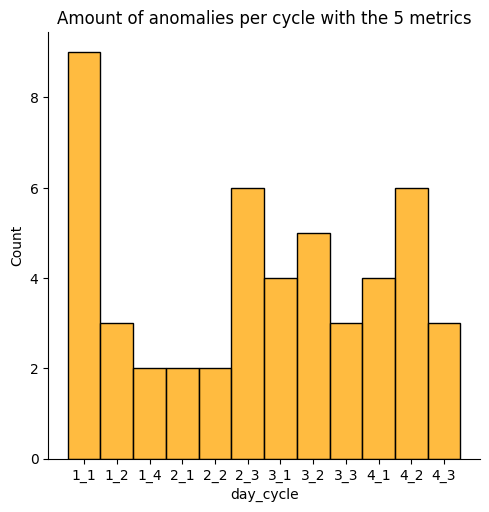

In [40]:
# we look at the first 11 columns of the general_df because they're the only ones on which we can do a comparison

sns.displot(data = anomaly_df[studied_col], x="day_cycle", color = 'blue')
plt.title('Amount of anomalies per cycle fitted with the mean only (first isolation forest)')

sns.displot(data = anomaly2_df[studied_col],x="day_cycle", color = 'orange')

plt.title('Amount of anomalies per cycle with the 5 metrics')

plt.show()

Taking into account several other metrics enabled us to have a broader view.

In [41]:
#Display of the anomalies

final_anomaly = anomaly2_df['day_cycle_window'].reset_index()
final_anomaly

,index,day_cycle_window
0,0,1_1_1
1,1,1_1_2
2,4,1_1_5
3,61,1_1_62
4,63,1_1_64
5,64,1_1_65
6,65,1_1_66
7,66,1_1_67
8,67,1_1_68
9,68,1_2_1


We have 49 abnormal windows with a choice of 3% errors in the data set

# Conclusion

We have tried to detect anomalies from a dataset we know nothing about.

With 3% of anomalies we seem to have (graphically) a coherent amont of outliers.

While the PCA is a usefull tool to display roughly the data, we have seen that it is not as accurate as the real data. Knowing that I used the graphical display of the Isolation Forest on the PCA to calibrate my fitting on the real data, we must remain critical regarding the results.

However the process can be improved, for example by taking more statistical metrics into account, or using the other methods considered (One Class SVM, ...).

There is only so much one can do without context. Some cycles with a lot of anomalies could be explained by external factors, such as a flight during a storm or by night. This is why it is important to have a second reading from an expert who will be able to enlighten certain aspects of the dataset.

Finally, as said in the introduction, if the dataset is intrinsecly flawed, without knowing in advance what we should expect, it is not possible to detect systemic errors (novelty detection)